## ADA Project : Milestone 2

### Analyzing User Behaviour

Quick placeholder

The Wikispeedia game leverages the complex web of wikipeedia articles to offer players a chance to test their knowledge and connection finding skills. In this project, we embark on an analytical journey to unravel one aspect of this network : the cognitive behaviour of players and it's outcome on in-game success. //TODO : give outline of what is done in the project .

### Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import seaborn as sns
import warnings
import urllib.parse
import auxiliary
warnings.filterwarnings('ignore')

###  Part 1 -  Data Overview and Pre-processing :

### 1) Data exploration :

Let's first explore the data and see statistics for each dataframe

In [2]:
# Read the finished paths dataset
finished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress','timestamp','durationInSec','path','rating'])

# Read the unfinished paths dataset
unfinished_paths = pd.read_csv("wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', skiprows = 17, names=['hashedIpAddress' ,  'timestamp' ,  'durationInSec' ,  'path' ,  'target'   ,'type'])

# Read the categories dataset
categories = pd.read_csv("wikispeedia_paths-and-graph/categories.tsv", sep='\t', skiprows = 12, names=['article', 'category'])

# links.tsv contains all links between articles. 
links = pd.read_csv("wikispeedia_paths-and-graph/links.tsv", sep='\t', skiprows = 11, names = ['link_source', 'link_target'])

Let's see the structure of each one of our datasets : 

In [3]:
print('finished_paths dataframe structure :')
finished_paths.head(5)

finished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN


In [4]:
print('unfinished_paths dataframe structure :')
unfinished_paths.head(5)

unfinished_paths dataframe structure :


,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [5]:
print('categories dataframe structure :')
categories.head(5)

categories dataframe structure :


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [6]:
print('links dataframe structure :')
links.head(5)

links dataframe structure :


,link_source,link_target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


We note that some article names appear with unusual characters, after a bit of inspection it is simply due to a character encoding mismatch (the wikipedia article names are given in utf-8 encoding) we can have see that :  

In [7]:
# Reading the first source string with the correct character encoding 
urllib.parse.unquote(links["link_source"].iloc[0])

'Áedán_mac_Gabráin'

We keep this in mind in case we need to uncover some article names, but since the dataset seems to be coherent in the encoding use this will not constitute a problem for our analyis.

We now ask ourselves the question, how are the links distributed among pages ? 

In order to answer our question we proceed by creating a histogram to see the distribution of outgoing and incoming links of articles : 

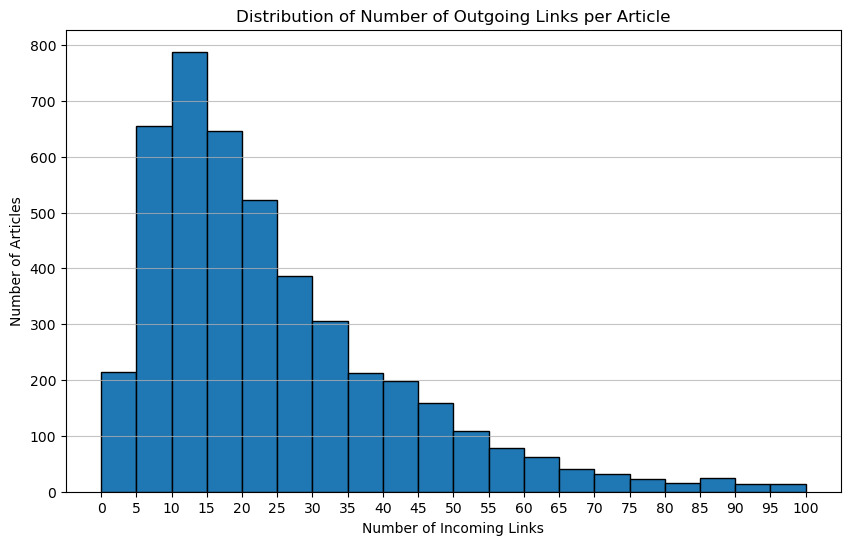

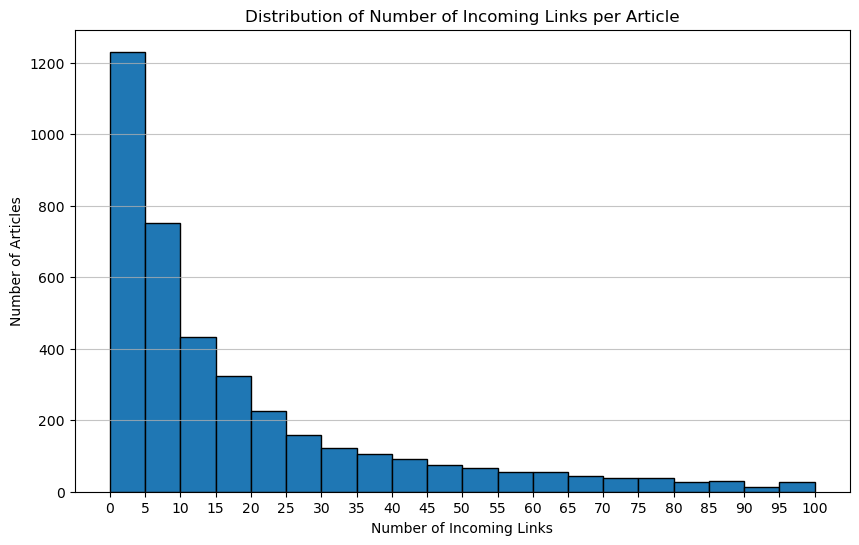

In [8]:
# Creating the outgoing and incoming links counts for each article
outgoing_link_counts = links.groupby('link_source').size()
incoming_link_count = links.groupby('link_target').size()

# Plotting the link distributions 
bins= range(0, 101, 5)
auxiliary.create_link_count_hist(outgoing_link_counts , bins, incoming=False)
auxiliary.create_link_count_hist(incoming_link_count , bins, incoming=True)

We clearly see the unbalance between the two types of links, suggesting the existence of a type of articles where the flow of links (either in or out) is much more important than the others. 

In order to explore how the users mak either conscious or uncnscious decisions that expoitthis netwok characteristic, we need to find a metric to measure an article's importance in the given topology : The Page Rank Algorithm

 ### 2) Page Rank Algorithm

We begin by constructing a directed graph of articles using the source and target in the links dataframe. We then use it to run the page rank algorithm.

In [9]:
# Creating the graph
articles_graph = nx.from_pandas_edgelist(links, 'link_source', 'link_target', create_using=nx.DiGraph())

In [10]:
# Running page rank algorithm to detect hubs
page_rank = nx.pagerank(articles_graph, alpha = 0.95)

In [11]:
# Getting the articles with the biggest page rank
top_articles = auxiliary.get_top_articles_by_page_rank(page_rank, top_n=20)

The top 20 articles in terms of page rank are:
United_States  :  0.009935032746117654
France  :  0.007229330714372333
Europe  :  0.0070304734690667175
United_Kingdom  :  0.00678777228452997
English_language  :  0.005449952687638059
Germany  :  0.005431830090461531
World_War_II  :  0.0051700876243443335
Latin  :  0.004939355069146878
India  :  0.0046305652074681665
England  :  0.004594809997467629
Japan  :  0.004294950215222161
Italy  :  0.004210976559873735
Time_zone  :  0.004194672678432141
Spain  :  0.004176952026957267
China  :  0.004051336363203921
Currency  :  0.004004790498849306
Russia  :  0.003989833476264975
Canada  :  0.003623844391861864
Christianity  :  0.0035685560331047794
List_of_countries_by_system_of_government  :  0.003525842378425106


Now that we have our importnace metric for each article, we will use this perspective to analyze the paths we have, we should note however that users have the ability to go back to an article once once visited (back clicks), these jumps are need to be filtered since they don't provide insights into the advancement of the player : 


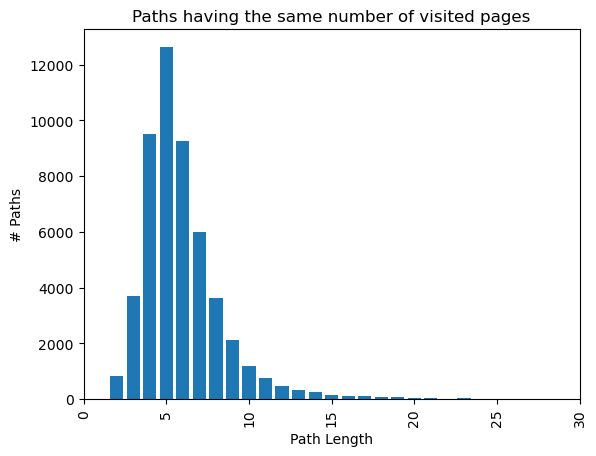

In [12]:
paths_rank_ = []

# Process each path
for i, row in finished_paths.iterrows():
    path_split = auxiliary.parse_and_clean_path(row['path'])
    path_split =  [page_rank.get(page, -1) for page in path_split] 
    path_split = auxiliary.pad_path(path_split)
    paths_rank_.append(path_split)

# Create DataFrame and calculate path lengths
paths_rank_df = pd.DataFrame(paths_rank_)
frequencies_length = auxiliary.calculate_path_lengths(paths_rank_df)


# Plot the path lengths frequencies
auxiliary.plot_path_length_frequencies(frequencies_length)

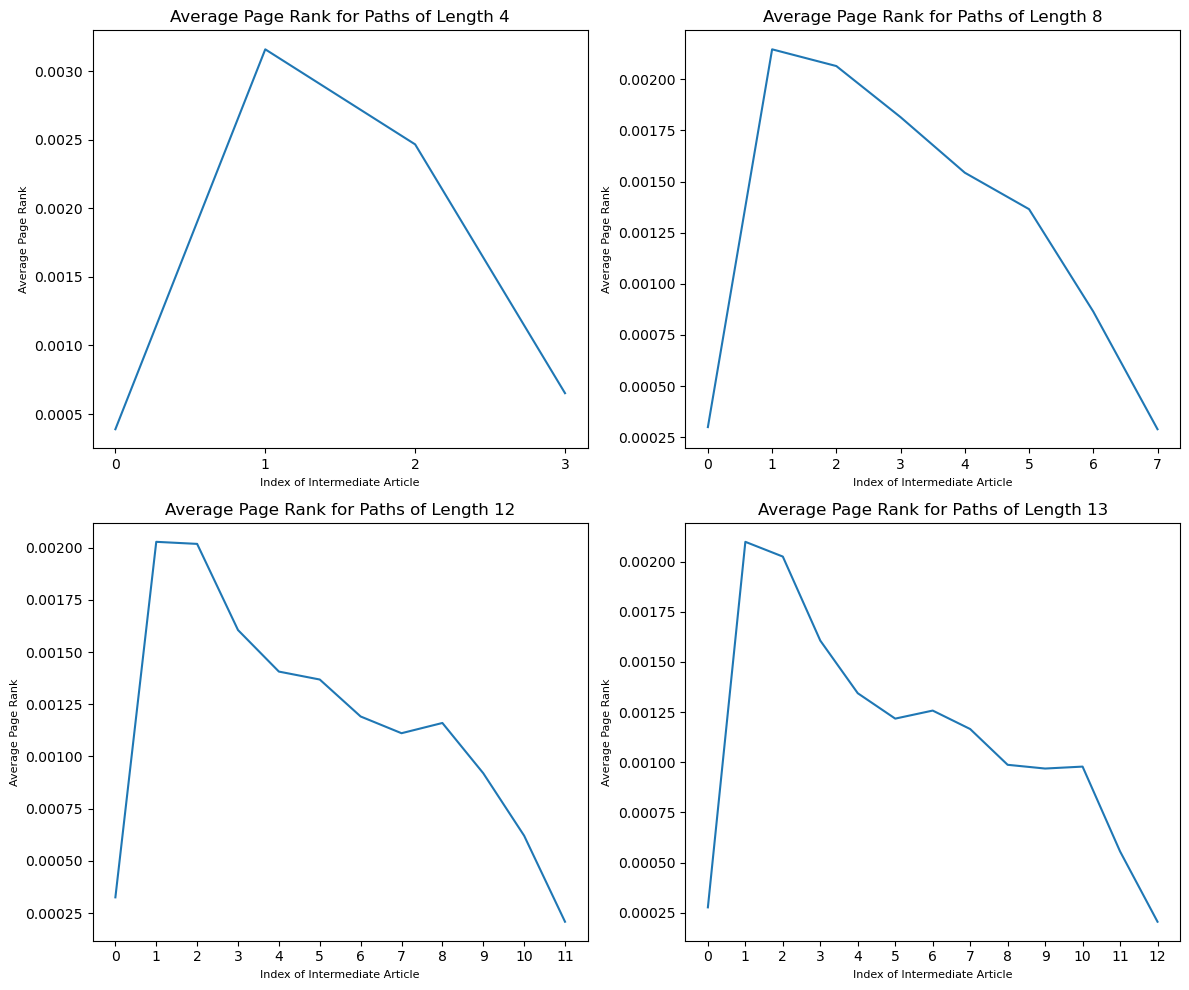

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Assuming paths_rank_df is already defined
path_lengths = [4, 8, 12, 13]
for i, len_ in enumerate(path_lengths):
    auxiliary.plot_avg_page_rank_for_path_length(paths_rank_df, len_, axs[i // 2, i % 2])

fig.tight_layout()
plt.show()

Discussion about the big jump :

the slow fall 

define UP PATH DOWN PATH notions 

### Part 2- Uncovering User Semantical links :

- talk about how users htink in categories and general semantical fields more than specific articles 
- we try to prove that but first we need to talk about the categories 
- we will analyze the categories, 
- make the paths of articles into paths of categories 
- see the connection between links in heatmap

###### Now we would like to consider the categories ....

In [14]:
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [15]:
# TODO : remove the comment 
#auxiliary.plot_categories_frequencies(categories, 'category')

In [16]:
# Column with the count of periods in the category
categories['period_count'] = categories['category'].apply(auxiliary.count_periods)

# Most specific category for each article
most_specific_category = categories.sort_values(by='period_count', ascending=False).drop_duplicates('article')
specific_categories = most_specific_category.drop(columns=['period_count'])
specific_categories = specific_categories.set_index('article')

specific_categories.head()

,category
article,
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
European_Greenfinch,subject.Science.Biology.Birds
Rutherfordium,subject.Science.Chemistry.Chemical_elements
Eurasian_Oystercatcher,subject.Science.Biology.Birds
Eurasian_Jay,subject.Science.Biology.Birds


In [17]:
#categories of the top articles 
categories_of_top_articles = []
for article in top_articles:
    current_categories = categories[categories['article']==article]['category'].tolist()
    # remove the categry 'subject.Countries' as all pages that have this category have other ones more specific like Geography.Asian/eurpean coutries
    filtered_categories = [elem for elem in current_categories if elem!= 'subject.Countries']

    categories_of_top_articles += filtered_categories

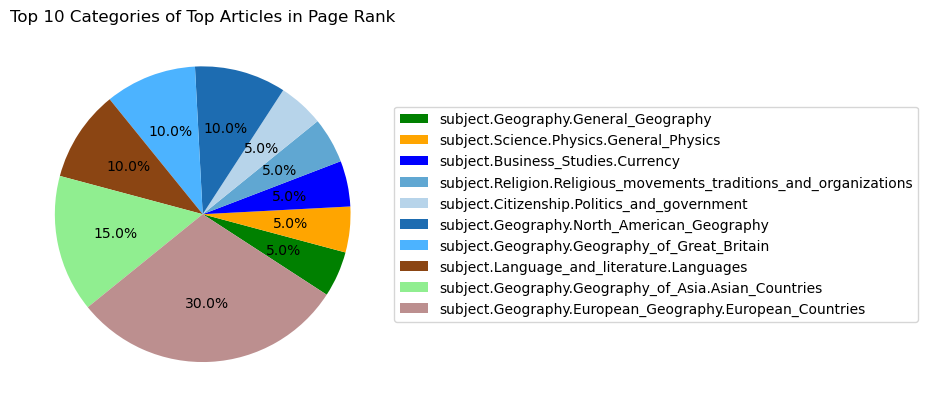

In [18]:
x=np.array(list(Counter(categories_of_top_articles).keys()))
y=np.array(list(Counter(categories_of_top_articles).values()))
colors=['green', 'orange','blue','#60a7d2','#b7d4ea','#1d6cb1', '#4cb3ff',  'saddlebrown','#90EE90', 'rosybrown']

auxiliary.plot_top_categories_pie_chart(x, y, colors, top_n=10) 

We observe that top ranked articles have categories mainly_ Countries, geography, history, science. This suggest that will have high traffic through those categories. Also we expect the hubs to be mostly part of those categories.

### Linking paths and categories

// TODO : compete the analysis here 

In [19]:
# Processing paths from finished and unfinished datasets relative to the highest-ranked page ('hub').

# Process finished paths in the upward direction (towards the hub) and track pages without a rank.
processed_finished_paths_upPath, pages_with_no_rank_finished_paths_upPath = \
    auxiliary.process_paths_on_rank(finished_paths, page_rank)  

# Process finished paths in the downward direction (away from the hub) and track pages without a rank.
processed_finished_paths_downPath, pages_with_no_rank_finished_paths_downPath = \
    auxiliary.process_paths_on_rank(finished_paths, page_rank, upPath=False)  

# Process unfinished paths in the upward direction (towards the hub) and track pages without a rank.
processed_unfinished_paths_upPath, pages_with_no_rank_unfinished_paths_upPath = \
    auxiliary.process_paths_on_rank(unfinished_paths, page_rank)  

# Process unfinished paths in the downward direction (away from the hub) and track pages without a rank.
processed_unfinished_paths_downPath, pages_with_no_rank_unfinished_paths_downPath = \
    auxiliary.process_paths_on_rank(unfinished_paths, page_rank, upPath=False)  

### 2 - Analyse finished Paths Behavior
## ************************************************************************************************************************

### 2-1 Finished Paths - UpPath

In this part , we will  be directed towards the "Up Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions leading up to the hub (estimated as the article with  the maximum page rank score) for each path. This information was previously calculated in the preceding section. Our objective here is to confirm whether the trend within this initial portion of the transitions involves links from a specific category to a more general one, in order to attain some hub.

In [20]:
# transforming the article paths into paths of categories for the UpPath Part of the finished paths 
processed_finished_paths_serie = pd.Series(processed_finished_paths_upPath)
category_finished_paths_upPath = processed_finished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_upPath.head(1)

0    [subject.History.General_history]
dtype: object

In [21]:
# build category connections for uppath categories 
category_connections_finished_paths_upPath = auxiliary.build_category_connections(category_finished_paths_upPath)
category_connections_finished_paths_upPath

,subject.People.USA_Presidents,subject.Music.Performers_and_composers,subject.Design_and_Technology.Road_transport,subject.Geography.General_Geography,subject.Everyday_life.Films,subject.Science.Biology.General_Biology,subject.Geography.Peoples,subject.Science.Chemistry.Chemical_elements,subject.Mathematics,subject.Science.Physics.Space_transport,...,subject.Geography.Central_and_South_American_Geography,subject.IT.Cryptography,subject.Citizenship.Politics_and_government,subject.IT.Websites_and_the_Internet,subject.Language_and_literature.Linguistics,subject.People.Historical_figures,subject.People.Geographers_and_explorers,subject.Everyday_life.Television,subject.Religion.Divinities,subject.Science.Biology.Mammals
subject.People.USA_Presidents,30,0,0,5,0,13,1,1,0,3,...,7,0,66,0,0,2,1,0,1,3
subject.Music.Performers_and_composers,0,8,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,1
subject.Design_and_Technology.Road_transport,0,2,6,0,0,0,0,7,0,0,...,1,0,1,0,0,0,0,0,0,0
subject.Geography.General_Geography,4,0,1,286,3,23,3,13,1,0,...,18,0,24,0,0,1,11,0,1,15
subject.Everyday_life.Films,0,0,1,0,49,0,0,0,0,8,...,0,0,3,0,12,0,0,17,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Historical_figures,1,0,0,15,2,1,1,5,0,0,...,2,0,11,0,3,30,1,2,2,2
subject.People.Geographers_and_explorers,0,0,0,10,0,2,1,0,2,2,...,3,0,1,0,0,1,5,0,0,2
subject.Everyday_life.Television,1,4,0,10,31,0,1,6,0,0,...,1,0,5,0,9,0,0,16,0,0
subject.Religion.Divinities,2,0,0,5,0,9,7,1,0,5,...,0,0,0,0,0,2,0,0,65,12


['IT', 'Mathematics', 'People', 'Music', 'Business_Studies', 'Religion', 'Geography', 'Citizenship', 'Science', 'History', 'Art', 'Design_and_Technology', 'Language_and_literature', 'Everyday_life']


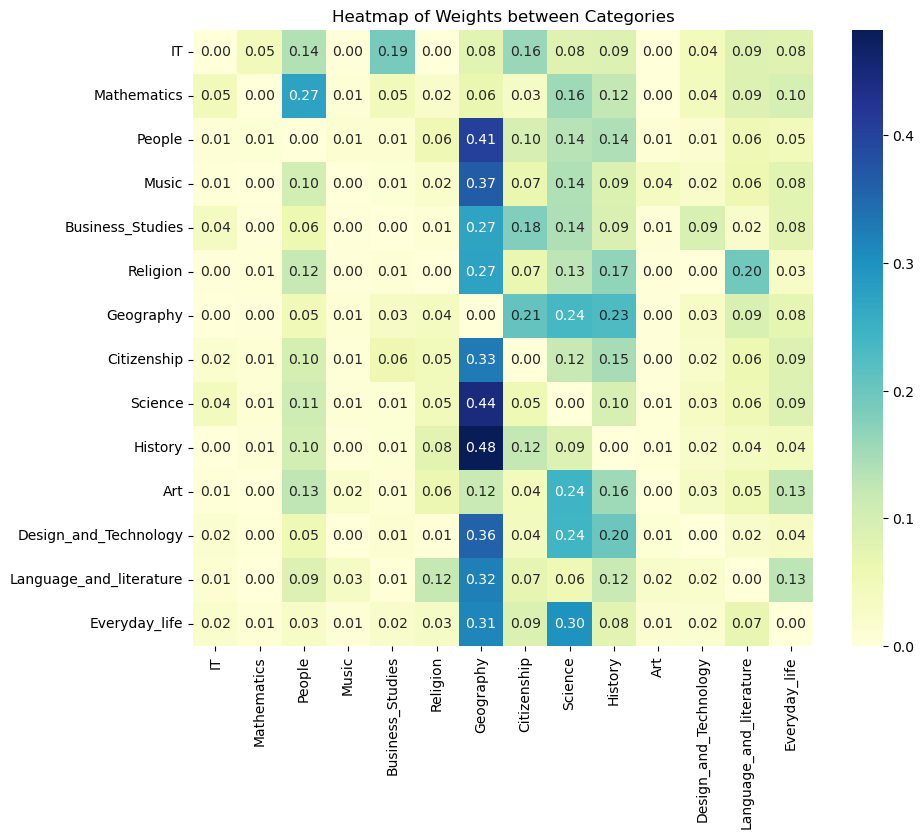

In [22]:
# comment
finished_upPath_general_adjacency = auxiliary.heatmap_general_categories(category_connections_finished_paths_upPath)

Discussion

Let's consider the graph of detected communities for the uppath of finished paths

### 2-2 Finished Paths - DownPath

In this part , we will  focus on the "Down Paths" segment of the succesfully finished paths. Specifically, we will utilize all the transitions starting from the hub up to the final destination.Since we disovered in the previous sub-section that the first 'Up Path' segment lead to a general category in general(corresponding to the category of the hub), we will be expecting to find that the Down Path(i.e the second part of the transitions) generally involves links from  general category to a specific one.

In [24]:
# transforming the article paths into paths of categories for the downPath Part of the finished paths 
processed_finished_paths_serie_downPath = pd.Series(processed_finished_paths_downPath)
category_finished_paths_downPath = processed_finished_paths_serie_downPath.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_finished_paths_downPath.head(1)

0    [subject.Geography.European_Geography, subject...
dtype: object

In [25]:
# build category connections 
category_connections_finished_paths_downPath = auxiliary.build_category_connections(category_finished_paths_downPath)
category_connections_finished_paths_downPath

,subject.People.USA_Presidents,subject.Music.Performers_and_composers,subject.Design_and_Technology.Road_transport,subject.Geography.General_Geography,subject.Everyday_life.Films,subject.Science.Biology.General_Biology,subject.Geography.Peoples,subject.Science.Chemistry.Chemical_elements,subject.Mathematics,subject.Science.Physics.Space_transport,...,subject.Geography.Central_and_South_American_Geography,subject.IT.Cryptography,subject.Citizenship.Politics_and_government,subject.IT.Websites_and_the_Internet,subject.Language_and_literature.Linguistics,subject.People.Historical_figures,subject.People.Geographers_and_explorers,subject.Everyday_life.Television,subject.Religion.Divinities,subject.Science.Biology.Mammals
subject.People.USA_Presidents,130,0,0,3,1,4,0,1,0,8,...,2,0,103,0,1,13,11,1,0,5
subject.Music.Performers_and_composers,0,43,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,0
subject.Design_and_Technology.Road_transport,0,0,19,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
subject.Geography.General_Geography,0,0,2,760,5,11,6,2,1,0,...,77,0,45,0,0,2,38,0,1,156
subject.Everyday_life.Films,0,2,0,0,383,0,0,0,0,7,...,0,0,1,0,2,0,0,66,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Historical_figures,2,0,0,3,0,0,1,1,1,0,...,1,0,2,0,0,32,1,0,0,0
subject.People.Geographers_and_explorers,2,0,0,8,0,2,0,4,0,26,...,13,0,1,0,0,0,11,0,0,2
subject.Everyday_life.Television,0,3,0,0,106,0,0,2,0,0,...,0,0,1,0,15,0,0,34,0,0
subject.Religion.Divinities,0,0,0,2,0,4,6,0,0,5,...,0,0,2,0,0,2,0,0,236,6


['IT', 'Mathematics', 'People', 'Music', 'Business_Studies', 'Religion', 'Geography', 'Citizenship', 'Science', 'History', 'Art', 'Design_and_Technology', 'Language_and_literature', 'Everyday_life']


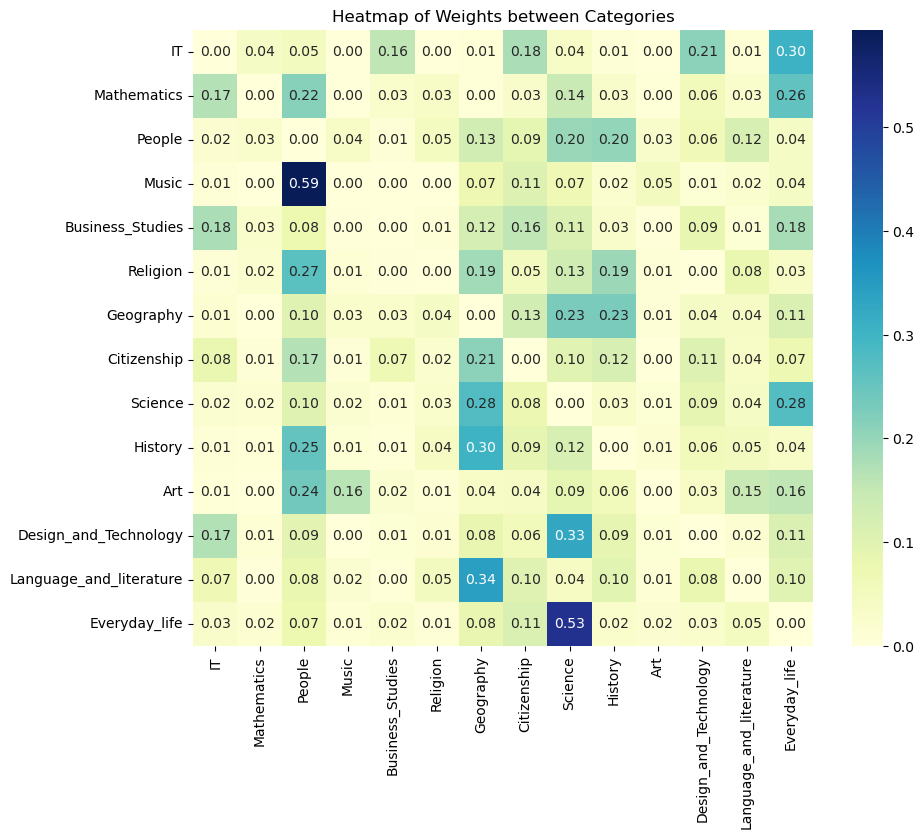

In [26]:
#comment
finished_downPath_general_adjacency = auxiliary.heatmap_general_categories(category_connections_finished_paths_downPath)

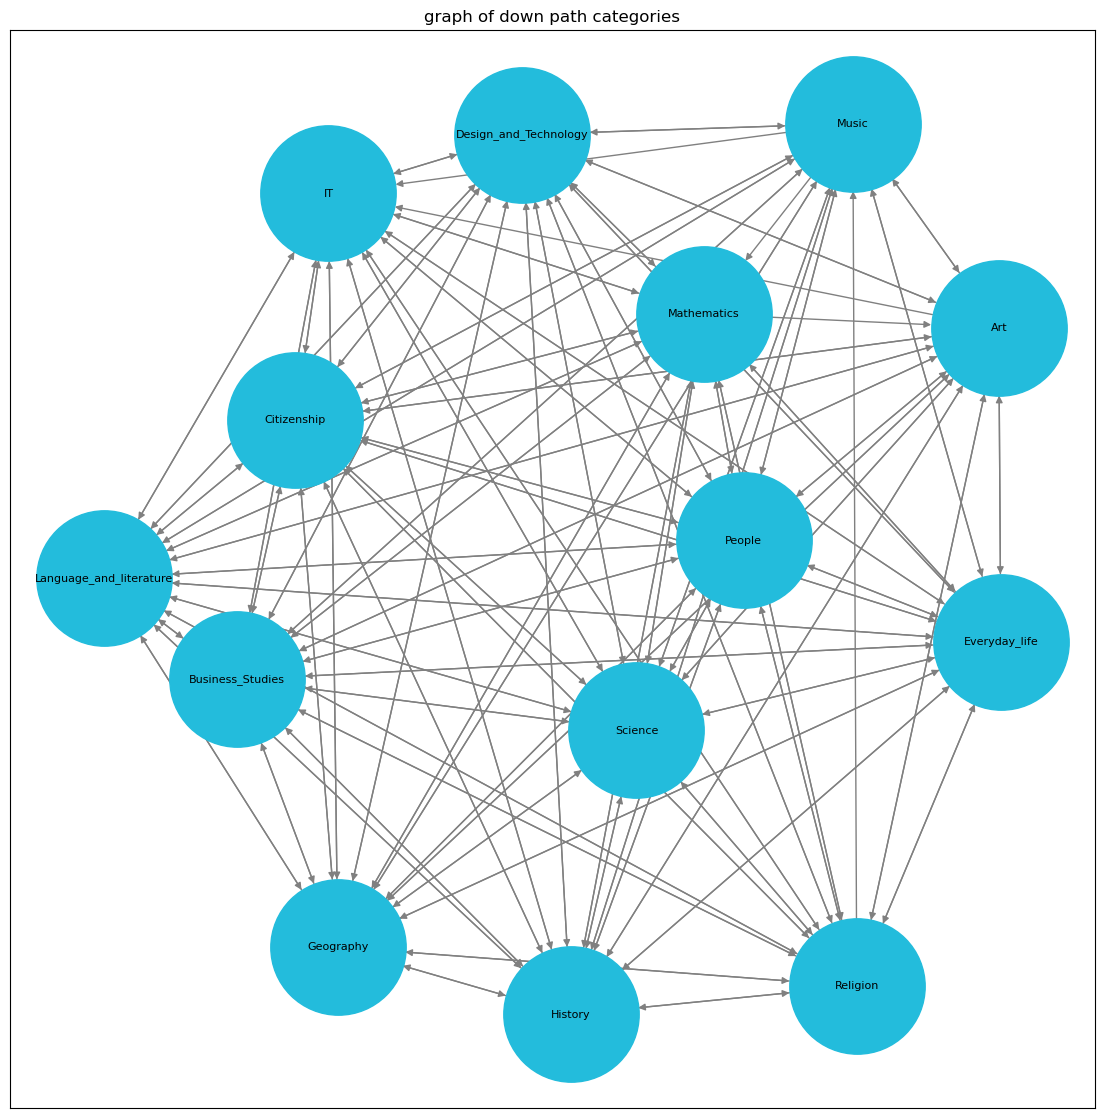

In [28]:
#graph of down path categories in finished paths
G_d= nx.from_pandas_adjacency(finished_downPath_general_adjacency, create_using = nx.DiGraph())

plt.figure(figsize=(14,14))
plt.title('graph of down path categories')
nx.draw_networkx(G_d, edge_color='gray',node_size=9500, font_size=8, node_color='#23bcdc')

// TODO: Discussion

### 3 - Analyse Unfinished Paths Behavior
## ************************************************************************************************************************

### 3-1 Unfinished Paths - UpPath

In this sub-part, we conduct a similar analysis of the "UpPath" as we did previously for the completed paths, but this time focusing on the unfinished paths. This approach will allow us to  explore the important differences between successful and unsuccessful paths.

In [29]:
# transforming the article paths into paths of categories for the UpPath Part of the unfinished paths 
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_upPath)   #check please
category_unfinished_paths_upPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_upPath.head()

0                                                   []
1                                                   []
2    [subject.Geography.African_Geography.African_C...
3                                                   []
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [30]:
#build category connections 
category_connections_unfinished_paths_upPath = auxiliary.build_category_connections(category_unfinished_paths_upPath)
category_connections_unfinished_paths_upPath

,subject.People.USA_Presidents,subject.Music.Performers_and_composers,subject.Design_and_Technology.Road_transport,subject.Geography.General_Geography,subject.Everyday_life.Films,subject.Science.Biology.General_Biology,subject.Geography.Peoples,subject.Science.Chemistry.Chemical_elements,subject.Mathematics,subject.Science.Physics.Space_transport,...,subject.Geography.Central_and_South_American_Geography,subject.IT.Cryptography,subject.Citizenship.Politics_and_government,subject.IT.Websites_and_the_Internet,subject.People.Historical_figures,subject.People.Geographers_and_explorers,subject.Everyday_life.Television,subject.Language_and_literature.Linguistics,subject.Religion.Divinities,subject.Science.Biology.Mammals
subject.People.USA_Presidents,10,0,0,0,1,6,0,0,0,3,...,3,0,31,0,0,0,2,0,0,1
subject.Music.Performers_and_composers,0,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
subject.Design_and_Technology.Road_transport,0,0,4,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
subject.Geography.General_Geography,0,0,0,104,1,4,3,3,0,0,...,7,0,16,0,1,6,0,0,1,9
subject.Everyday_life.Films,1,0,0,0,39,0,0,0,0,4,...,0,0,2,0,0,0,9,2,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Geographers_and_explorers,0,0,0,3,0,1,0,0,0,1,...,3,0,1,0,0,3,0,0,0,1
subject.Everyday_life.Television,1,2,0,3,20,0,1,0,0,0,...,0,0,3,0,0,0,8,1,0,0
subject.Language_and_literature.Linguistics,0,0,0,0,1,3,0,1,0,0,...,0,0,0,0,0,0,0,16,0,2
subject.Religion.Divinities,1,0,0,0,0,2,0,1,0,1,...,0,0,1,0,2,0,2,0,28,2


['IT', 'Mathematics', 'People', 'Music', 'Business_Studies', 'Religion', 'Geography', 'Citizenship', 'Science', 'History', 'Art', 'Design_and_Technology', 'Language_and_literature', 'Everyday_life']


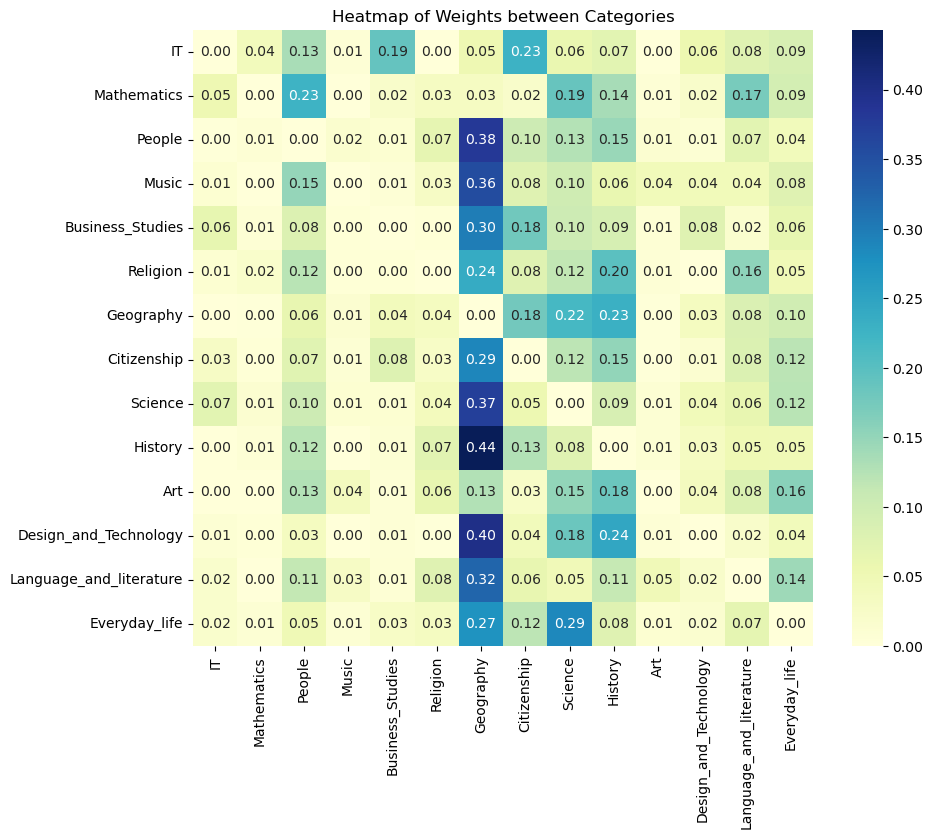

In [31]:
tmp = auxiliary.heatmap_general_categories(category_connections_unfinished_paths_upPath)

### 3-2 Unfinished Paths - DownPath

In this subsection , We will conduct the same analysis for the DownPath of the  unfinished paths as we did for the finished paths. Given that we observed the same behavior in both paths for the UpPath segment during the previous subsection, we expect that the finished and unfinished paths both have the same behavior also for the DownPath, which means that we will observe links generally going from a general category to a more specific one.

In [33]:
# transforming the article paths into paths of categories  
processed_unfinished_paths_serie = pd.Series(processed_unfinished_paths_downPath)
category_unfinished_paths_downPath = processed_unfinished_paths_serie.map(lambda path: [specific_categories.loc[article, 'category'] if article in specific_categories.index else 'Unknown_Category' for article in path])
category_unfinished_paths_downPath.head()

0                        [subject.Everyday_life.Films]
1                  [subject.People.Historical_figures]
2    [subject.Citizenship.Politics_and_government, ...
3    [subject.Geography.Central_and_South_American_...
4    [subject.Geography.Central_and_South_American_...
dtype: object

In [34]:
#Build category connections
category_connections_unfinished_paths_downPath = auxiliary.build_category_connections(category_unfinished_paths_downPath)
category_connections_unfinished_paths_downPath

,subject.People.USA_Presidents,subject.Music.Performers_and_composers,subject.Design_and_Technology.Road_transport,subject.Everyday_life.Films,subject.Geography.General_Geography,subject.Science.Biology.General_Biology,subject.Geography.Peoples,subject.Science.Chemistry.Chemical_elements,subject.Science.Physics.Space_transport,subject.Mathematics,...,subject.Geography.Central_and_South_American_Geography,subject.IT.Cryptography,subject.Citizenship.Politics_and_government,subject.IT.Websites_and_the_Internet,subject.People.Historical_figures,subject.People.Geographers_and_explorers,subject.Everyday_life.Television,subject.Language_and_literature.Linguistics,subject.Religion.Divinities,subject.Science.Biology.Mammals
subject.People.USA_Presidents,37,0,0,0,0,7,0,1,3,0,...,0,0,30,0,2,3,1,0,1,1
subject.Music.Performers_and_composers,1,8,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
subject.Design_and_Technology.Road_transport,0,0,10,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
subject.Everyday_life.Films,1,0,0,107,0,0,0,0,3,0,...,0,0,0,2,0,0,28,3,0,3
subject.Geography.General_Geography,0,0,1,1,213,8,0,1,0,2,...,13,0,16,1,0,9,0,0,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
subject.People.Geographers_and_explorers,0,0,0,0,6,2,0,0,10,1,...,6,0,1,0,0,3,0,0,0,0
subject.Everyday_life.Television,0,3,0,48,0,0,0,0,0,0,...,0,0,3,0,0,0,25,11,0,0
subject.Language_and_literature.Linguistics,0,0,0,0,2,3,0,1,3,0,...,0,0,1,2,1,0,0,16,0,2
subject.Religion.Divinities,1,0,0,0,0,0,3,0,2,0,...,0,0,0,1,2,0,0,1,38,3


['IT', 'Mathematics', 'People', 'Music', 'Business_Studies', 'Religion', 'Geography', 'Citizenship', 'Science', 'History', 'Art', 'Design_and_Technology', 'Language_and_literature', 'Everyday_life']


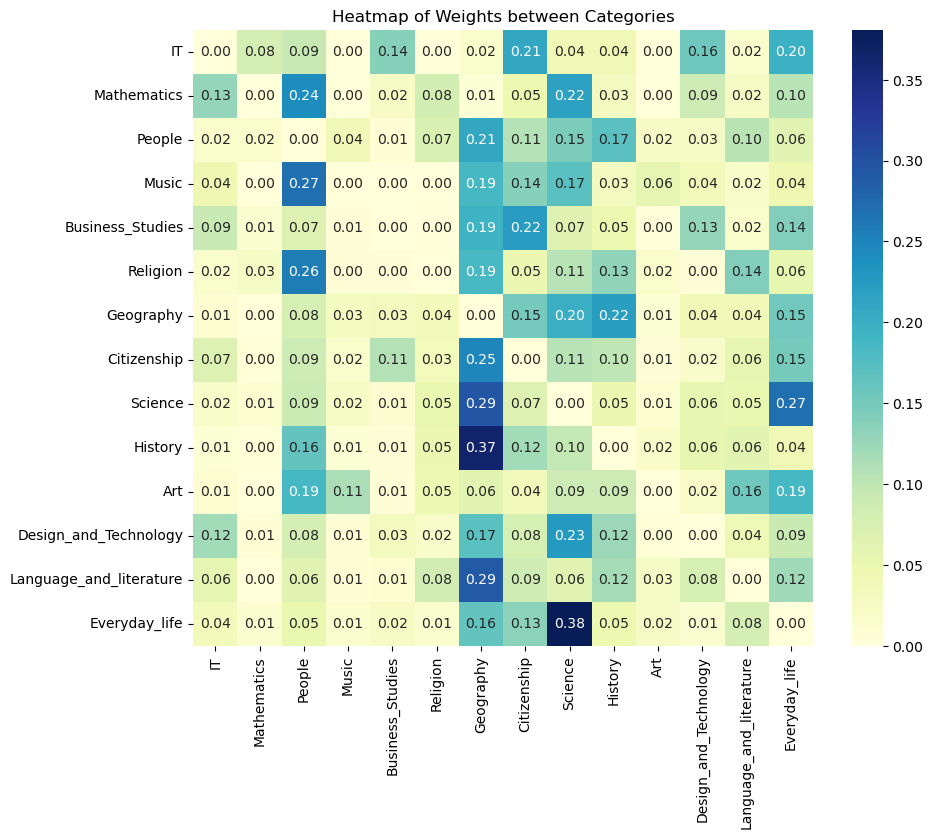

In [35]:
# show haetmap for category_connections of unfinished_paths  - downPath
t2 = auxiliary.heatmap_general_categories(category_connections_unfinished_paths_downPath)

#### 4 - Compare destinations of finished and unfinished Paths
## ************************************************************************************************************************

### Part 3

In the previous part, we observed that both finished and unfinshed paths have exactly the same pattern : i.e the first segment (UpPath) of the path

generaly escapes from specific categories to more general ones, up until a hub, then the second segment(DownPath) links have tendency to go from general categories to more specific ones , this suggests that the difference between finished and unfinshed paths is not really the starting point , since we can reach a hub starting from anyhub, but the main difference might be in the final destination article, in this section we will try to analyse differences between the destinations of both finished and unfinished paths by comparing the distribution of their in-degrees.

In [38]:
G = articles_graph

# We recover all the in-degrees of the destinations of the unfinished paths
unfinished_paths_in_degrees = unfinished_paths["target"].apply(lambda t: G.in_degree(t)).fillna(0).apply(lambda t : t if isinstance(t, (int)) else 0) + 1 

# We recover all the in-degrees of the destinations of the finished paths
finished_paths_in_degrees = finished_paths["path"].apply(lambda t : G.in_degree(t.split(";")[-1])).apply(lambda t : t if isinstance(t, (int)) else 0) +1    

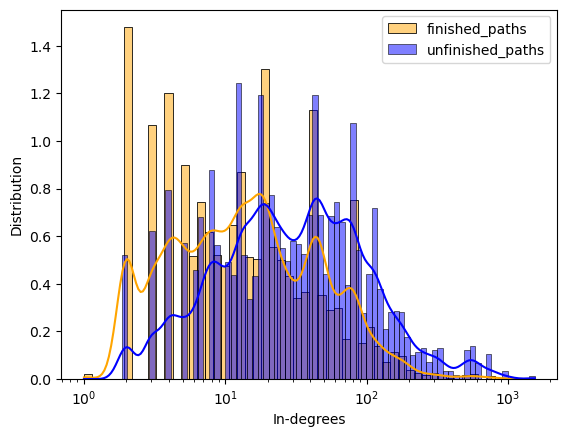

In [39]:
 auxiliary.plot_degree_distribution(unfinished_paths_in_degrees, finished_paths_in_degrees)

In this histogram, it is clear that the destinations of unfinished paths are more likely to have lower in-degrees, indicating greater difficulty in reaching those destinations. Also, we can see that starting from an in-degree of 20 degrees, the destinations of finished paths have a higher probability. This observation aligns with intuition, as higher in-degrees suggest increased popularity of an article, making it more accessible and easier to reach.

### Model for predicting the success of a path : Page rank based model

We observed in the previous parts that logical behavior of players is the same for the finished and unfinished paths. We also observed that the indegree of the targets changes between finished and unfinished paths. We will analyze what influences the success or failure. We considered the following features:

-    #### target_rank  : the page rank of the target page
-    #### starting_rank  the page rank of the starting page
-    #### hub_rank: the page rank of the hub
-    #### indegrees: number of ingoing edges
-    #### num_of_games: number of played games


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [41]:
player_game_count = auxiliary.compute_games_played(finished_paths, unfinished_paths)
p1, p2 = auxiliary.user_games_played(finished_paths, unfinished_paths, player_game_count)

In [42]:
finished_targets, finished_starting, unfinished_targets, unfinished_starting = auxiliary.get_targets_and_starting_points(finished_paths, unfinished_paths)
finished_targets_rank, finished_starting_rank = auxiliary.associate_targets_and_starting_points_with_ranks(finished_targets, finished_starting, page_rank)
unfinished_targets_rank, unfinished_starting_rank = auxiliary.associate_targets_and_starting_points_with_ranks(unfinished_targets, unfinished_starting, page_rank)

In [43]:
l_finished, l_unfinished = auxiliary.get_hub_ranks(processed_finished_paths_downPath, processed_unfinished_paths_downPath, page_rank)

# Labeling the targets
finished_data = pd.DataFrame({'target_rank': finished_targets_rank, 'label': 1, 'starting_rank ': finished_starting_rank , 'hub_rank ': l_finished })
unfinished_data = pd.DataFrame({'target_rank': unfinished_targets_rank, 'label': 0, 'starting_rank ': unfinished_starting_rank, 'hub_rank ': l_unfinished  })

# Combining the data 
combined_data = pd.concat([finished_data, unfinished_data])

In [44]:
# Extracting the label column
y = combined_data['label']
X = combined_data.drop(columns=["label"])  

#we recover all the in-degrees of the destinations of the un.finished paths
X = auxiliary.calculate_and_update_indegrees(X, finished_paths, unfinished_paths, articles_graph)

#standardize
X = auxiliary.standardize_data(X, p1, p2)

#split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.head()

,target_rank,starting_rank,hub_rank,indegrees,num_of_games
371,-0.443886,-0.313330,0.117046,-0.362368,61
33856,-0.522977,-0.485599,1.213039,-0.492798,6
6636,-0.213051,0.247690,-0.347991,-0.134116,172
37870,-0.552582,-0.490558,0.235113,-0.503667,21
15878,0.515319,0.705661,0.288831,0.333257,60


In [45]:
# Train a logistic regression model
model = auxiliary.train_logistic_regression(X_train, y_train)

# Construct a dataframe that contains the coefficients of the features
features_coef = auxiliary.feature_coefficients(model, X_train)

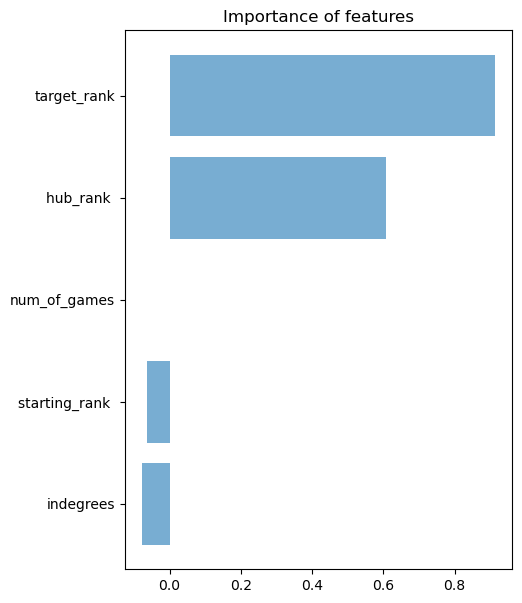

Accuracy: 0.7230971128608924
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.27      0.39      2493
           1       0.73      0.95      0.82      5127

    accuracy                           0.72      7620
   macro avg       0.71      0.61      0.60      7620
weighted avg       0.72      0.72      0.68      7620



In [46]:
# plot horizontal hist of the importance of the feature coefficients
auxiliary.plot_feature_coefficients(features_coef)

# Evaluate the model
accuracy, report = auxiliary.evaluate_model(model, X_test, y_test)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

From the plot, we can see that the experience of the player does not influence on his performance. The most dominant coefficients are the page rank score of the hub and the target. On the other side, the rank of the starting point does not impact the outcome of the game.

### Part 4 :

In this section, we'll concentrate on science-related categories. Our aim is to identify semantic connections among these categories, grouping them into clusters of similar ones. This approach is guided by human intuition and reasoning. Since we've found that only the DownPath from the successfully completed paths is effective for semantic analysis, we will only focus on this part of the paths to construct a similarity matrix for the science categories.

In [47]:
#Copy of the finished_paths
finished_paths_tmp = finished_paths.copy()

#Keeping only the finished_paths with destination belonging to the science category, we also added a specific_category and general_category columns
finished_paths_tmp["specific_categ"] = [specific_categories.loc[t.split(";")[-1], 'category'] if t.split(";")[-1] in specific_categories.index else 'Unknown_Category'  for t in finished_paths_tmp["path"]]
finished_paths_tmp["general_categ"] = [ t.split(".")[1] if t!= "Unknown_Category" else "Unknown_Category" for t in   finished_paths_tmp["specific_categ"] ]
finished_paths_tmp = finished_paths_tmp[finished_paths_tmp["general_categ"] == "Science"]


In [48]:
data_frame_science= auxiliary.compute_similarity_matrix(finished_paths_tmp, categories)

In [49]:
# Create a graph from the DataFrame
G = nx.from_pandas_adjacency(data_frame_science, create_using=nx.DiGraph())

# Rename nodes to remove the 'subject.Science' prefix
G = nx.relabel_nodes(G, lambda x: x.replace('subject.Science', ''))

# Find the top 3 most related topics for each category
top_3_related = {}
for node in G.nodes():
    neighbors = G[node]
    top_3_related[node] = sorted(neighbors, key=lambda x: neighbors[x]['weight'], reverse=True)[:3]

# Create a new directed graph with only the top 3 related edges
G_top_3 = nx.DiGraph()
for node, related_nodes in top_3_related.items():
    for related_node in related_nodes:
        if (node, related_node) in G.edges():
            weight = G.get_edge_data(node, related_node)['weight']
            G_top_3.add_edge(node, related_node, weight=weight)

# Improved node positioning using Kamada-Kawai layout, this will be useful in order to see more clearly the categories
pos = nx.kamada_kawai_layout(G_top_3)

adjusted_pos = auxiliary.adjust_label_pos(pos)

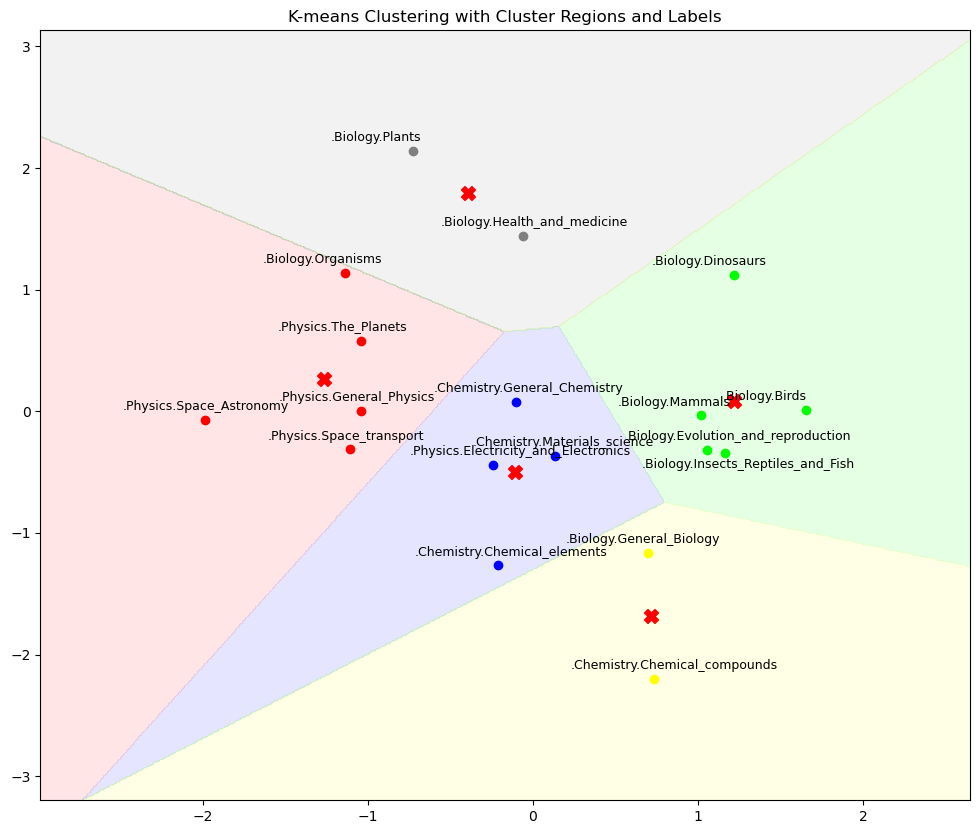

In [51]:
df_dict = pd.DataFrame.from_dict(adjusted_pos, orient='index')
auxiliary.kmeans_clustering_and_plot(df_dict)

The graph illustrates that the pathways taken by players in the downpath of successfully completed paths demonstrate a coherent and semantic grouping of science categories. For instance, there is a distinct Biology cluster grouping categories like Insects, Reptiles, Birds, and Evolution and Reproduction. On the left side of the graph, a Physics cluster is evident, containing categories such as Space Astronomy, The Planets, and Space Transport. This clustering reflects a logical organization of scientific disciplines as navigated by the players.